Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# modify to where you store your project data including utils
datadir = "/content/drive/My Drive/Project 5/mp5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

In [3]:
# !pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall
# !pip install opencv-contrib-python==4.6.0.66 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [4]:
def score_projection(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  # TO DO

  threshold = 1
  N = pt1.shape[1] # number of points
  inliers = np.zeros(N)
  score = 0
  # print("Num pts", N)

  # for i in range(N):
  #   if np.sqrt((pt2[0,i]-pt1[0,i])**2 + (pt2[1,i]-pt1[1,i])**2) < threshold:
  #     score += 1
  #     inliers[i] = 1

  # Perhaps slightly more efficient implementation because it doesn't use a loop
  dx = pt2[0,:]-pt1[0,:] 
  dy = pt2[1,:]-pt1[1,:]
  ok_t = np.sqrt(dx**2 + dy**2) < 1
  score = sum(ok_t)
  inliers[ok_t] = 1

  # print("Score:", score)
  # print("Inliers:", inliers)

  return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32': # Converts data type from float to np.uint8 cause its smaller
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000 # Number of iterations
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)
        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [5]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO

    # Implemented using the DLT
    # u is x coordinate in pts1, so pts1[0,i]
    # v is y coordinate in pts1, so pts1[1,i]
    # u' is x coordinate in pts2, so pts2[0,i]
    # v' is y coordinate in pts2, so pts2[1,i]

    # print(pts1)
    # print(pts1.shape[1])
    A = np.zeros((pts1.shape[1]*2,9))
    for i in range(pts1.shape[1]): # Need 2 rows for each point in pts1
      u = pts1[0,i]
      v = pts1[1,i]
      up = pts2[0,i]
      vp = pts2[1,i]
      A[2*i,:] = [-u,-v,-1,0,0,0,u*up,v*up,up] # formula from slides
      A[2*i+1,:] = [0,0,0,-u,-v,-1,u*vp,v*vp,vp]

    [U,S,V] = svd(A) # from slides; svd is imported above
    H = V[-1,:]
    H /= H[-1]
    H = np.reshape(H,(3,3))
    # print(H)

    return H

best score: 160.000000
H: 
[[ 1.00000000e+00  4.63228830e-02 -2.04661811e+02]
 [ 1.21169620e-02  9.51733776e-01 -1.50332473e+01]
 [ 3.74422111e-04  3.22065720e-05  8.17601840e-01]]
Box 1: [[300 400 400 300 300]
 [100 100 200 200 100]
 [  1   1   1   1   1]]
Box 2 [[107.13236921 206.02952924 210.10499537 111.71095741 107.13236921]
 [ 89.77688143  87.56199588 185.00520928 191.10889606  89.77688143]
 [  1.           1.           1.           1.           1.        ]]


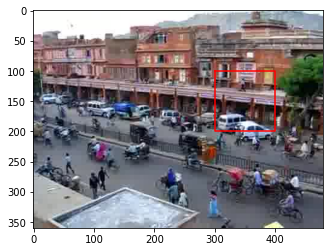

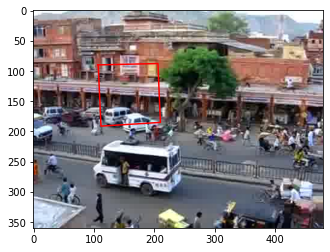

In [6]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print("H: ") 
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
print("Box 1:", box_pts)
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2
box_pts2 = np.dot(H, box_pts)
box_pts2 /= box_pts2[-1]
print("Box 2", box_pts2)
plt.figure()
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(box_pts2[0,:], box_pts2[1, :], 'r-')

# projIm1 = cv2.warpPerspective(im1, T1, (W, H))
# projIm2 = cv2.warpPerspective(im2, T2, (W, H))
# blendOut = utils.blendImages(projIm1, projIm2) 



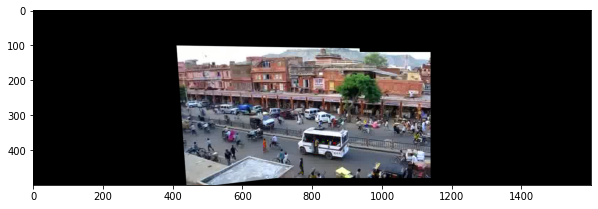

In [8]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images

T1 = Tr.dot(H)
T2 = Tr.astype(np.float32)
projIm1 = cv2.warpPerspective(im1, T1, (projectedWidth, projectedHeight))
projIm2 = cv2.warpPerspective(im2, T2, (projectedWidth, projectedHeight))
blendOut = utils.blendImages(projIm1, projIm2) 

plt.figure(figsize=(10,10))
plt.imshow(blendOut[:,:,[2,1,0]])

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


In [7]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

# Read all images into np array called frames of length n, the number of key frames
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 1600
projectedHeight = 500

# First computer homographies between frames 270/630, and 450. frames[2] is f450, the central frame

H12 = auto_homography(frames[1],frames[2], computeHomography)
H32 = auto_homography(frames[3],frames[2], computeHomography)
H01 = auto_homography(frames[0],frames[1], computeHomography)
H43 = auto_homography(frames[4],frames[3], computeHomography)
H02 = np.dot(H01,H12)
H42 = np.dot(H43,H32)

best score: 158.000000
best score: 138.000000
best score: 211.000000
best score: 100.000000


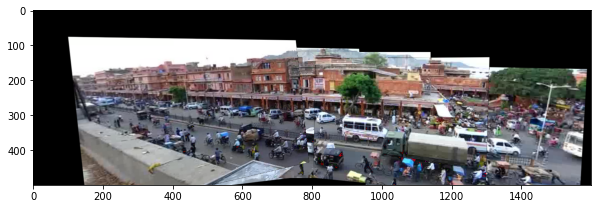

In [10]:
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)
T12 = Tr.dot(H12)
proj270 = cv2.warpPerspective(frames[1], T12, (projectedWidth, projectedHeight))
proj450 = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
blend1 = utils.blendImages(proj270, proj450) 

T32 = Tr.dot(H32)
proj630 = cv2.warpPerspective(frames[3], T32, (projectedWidth, projectedHeight))
blend2 = utils.blendImages(blend1, proj630) 

T02 = Tr.dot(H02)
proj90 = cv2.warpPerspective(frames[0], T02, (projectedWidth, projectedHeight)) 
blend3 = utils.blendImages(blend2, proj90)

T42 = Tr.dot(H42)
proj810 = cv2.warpPerspective(frames[4], T42, (projectedWidth, projectedHeight)) 

blend4 = utils.blendImages(proj810, blend3)

plt.figure(figsize=(10,10))
plt.imshow(blend4[:,:,[2,1,0]])

# plt.figure(figsize=(10,10))
# plt.imshow(blendOut[:,:,[2,1,0]])

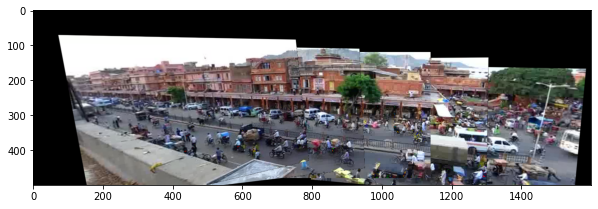

In [ ]:
# Alternate method of making a panorama using a for loop

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)

projs = np.zeros((5, projectedHeight, projectedWidth, 3))
projs[0] = cv2.warpPerspective(frames[0], Tr.dot(H02), (projectedWidth, projectedHeight))
projs[1] = cv2.warpPerspective(frames[1], Tr.dot(H12), (projectedWidth, projectedHeight))
projs[2] = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
projs[3] = cv2.warpPerspective(frames[3], Tr.dot(H32), (projectedWidth, projectedHeight))
projs[4] = cv2.warpPerspective(frames[4], Tr.dot(H42), (projectedWidth, projectedHeight))

old_blend = projs[0]
for i in range(1,projs.shape[0]):
  blend = utils.blendImages(projs[i], old_blend)
  old_blend = blend

plt.figure(figsize=(10,10))
plt.imshow(blend[:,:,[2,1,0]])

# plt.figure(figsize=(10,10))
# plt.imshow(blendOut[:,:,[2,1,0]])

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [8]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

# Save all the frames as images in the np array frames[]
for idx, file_i in enumerate(filenames): 
  frames[idx] = cv2.imread(file_i)

In [ ]:
# TO DO part 3 solution

# create your video (see tips)

# Steps: 
# 1. Create homographies mapping each plane to nearest key frame
# The homography is H(frame, key) * H(key, center)
# 2. Warp each frame with its homography and save it as a frame
# 3. Combine all of the frames into a video using ffmeg

# Calculate homographies 
# 900 Frames; First 
# projs[0-4] is the five key_frames in ascending order

H_key = np.zeros((key_frames_idx.shape[0],3,3))
H_key[1] = auto_homography(frames[270-1],frames[450-1], computeHomography) #H12
H_key[3] = auto_homography(frames[630-1],frames[450-1], computeHomography) #H32
H_key[0] = np.dot(auto_homography(frames[90-1],frames[270-1], computeHomography),H_key[1]) # 0 to 1, 1 to 2
H_key[4] = np.dot(auto_homography(frames[810-1],frames[630-1], computeHomography),H_key[3]) # 4 to 3, 3 to 2
H_key[2] = np.identity(3)

Hs = np.zeros((frameCount,3,3))
for f in range(frameCount): # f is frame number
  # if(f % 50 != 0):
  #   continue
  key_frame = np.argmin(np.abs(key_frames_idx - f))
  # print(key_frame)
  H_toKey = auto_homography(frames[f],frames[key_frames_idx[key_frame]], computeHomography)
  Hs[f] = np.dot(H_toKey,H_key[key_frame]) # Maps frame to key, key to center
  # print("Frame", f, "Key Frame:", key_frames_idx[key_frame])


best score: 160.000000
best score: 141.000000
best score: 212.000000
best score: 96.000000
best score: 370.000000
best score: 368.000000
best score: 392.000000
best score: 368.000000
best score: 396.000000
best score: 391.000000
best score: 407.000000
best score: 391.000000
best score: 406.000000
best score: 428.000000
best score: 436.000000
best score: 398.000000
best score: 422.000000
best score: 404.000000
best score: 429.000000
best score: 421.000000
best score: 434.000000
best score: 431.000000
best score: 427.000000
best score: 427.000000
best score: 406.000000
best score: 430.000000
best score: 433.000000
best score: 443.000000
best score: 447.000000
best score: 428.000000
best score: 417.000000
best score: 429.000000
best score: 450.000000
best score: 447.000000
best score: 454.000000
best score: 441.000000
best score: 458.000000
best score: 464.000000
best score: 445.000000
best score: 465.000000
best score: 459.000000
best score: 452.000000
best score: 439.000000
best score: 

<ipython-input-5-9202984a7e90>:95: RuntimeWarning: divide by zero encountered in true_divide
  score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])


best score: 276.000000
best score: 255.000000
best score: 265.000000
best score: 293.000000
best score: 325.000000
best score: 320.000000
best score: 289.000000
best score: 274.000000
best score: 280.000000
best score: 318.000000
best score: 310.000000
best score: 324.000000
best score: 362.000000
best score: 363.000000
best score: 325.000000
best score: 330.000000
best score: 334.000000
best score: 365.000000
best score: 398.000000
best score: 382.000000
best score: 393.000000
best score: 425.000000
best score: 414.000000
best score: 397.000000
best score: 471.000000
best score: 444.000000
best score: 675.000000
best score: 2816.000000
best score: 420.000000
best score: 398.000000
best score: 373.000000
best score: 388.000000
best score: 310.000000
best score: 312.000000
best score: 309.000000
best score: 300.000000
best score: 289.000000
best score: 297.000000
best score: 368.000000
best score: 324.000000
best score: 351.000000
best score: 344.000000
best score: 300.000000
best score

In [9]:
# Save and load homographies so we don't need to calculate them again
# np.save(datadir + "homographies.npy", Hs)
Hs = np.load(datadir + "homographies.npy")

In [13]:
# Make warped images as frames 
projectedWidth = 1600
projectedHeight = 500

Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)

# projs = np.zeros((frameCount, projectedHeight, projectedWidth, 3))
projected_frames = np.zeros((frameCount, projectedHeight, projectedWidth, 3),dtype=np.uint8)
for f in range(0,frameCount):
  if f == 450-1:
    im_warped = cv2.warpPerspective(frames[f], Tr_f, (projectedWidth, projectedHeight))
  else: 
    im_warped = cv2.warpPerspective(frames[f], Tr.dot(Hs[f]), (projectedWidth, projectedHeight))
  # cv2.imwrite(datadir + "warped/a{:04d}.jpg".format(f+1), im_warped)
  projected_frames[f] = im_warped

In [77]:
# Save projection frames as np array so we can use it later
np.save(datadir + "projections.npy", projected_frames)

In [46]:
# Save projected frames as an output video aligned to reference plane
utils.imageFolder2mpeg(datadir + 'warped', output_path = datadir + 'results/output_video.mpeg', fps=30)

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [10]:
# Load projected frames np array instead of calculating it
projected_frames = np.load(datadir + "projections.npy")

In [11]:
# TO DO part 4

# Strategy: Find median pixel value over time

# projected_frames = np.zeros((frameCount, 500, 1600, 3),dtype=np.uint8)

# dir_frames =  datadir + 'warped'
# files_info = os.scandir(dir_frames)

# file_names = [f.path for f in files_info if f.name.endswith(".jpg")]
# print(filenames)
# file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# for idx, file in enumerate(filenames):
#   if idx == 0:
#     print(cv2.imread(file).shape)
#   projected_frames[idx] = cv2.imread(file)

background = np.apply_along_axis(lambda v: np.median(v[np.nonzero(v)]), 0, projected_frames)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
# Save and load homographies so we don't need to calculate them again
# np.save(datadir + "background.npy", background)
background = np.load(datadir + "background.npy")

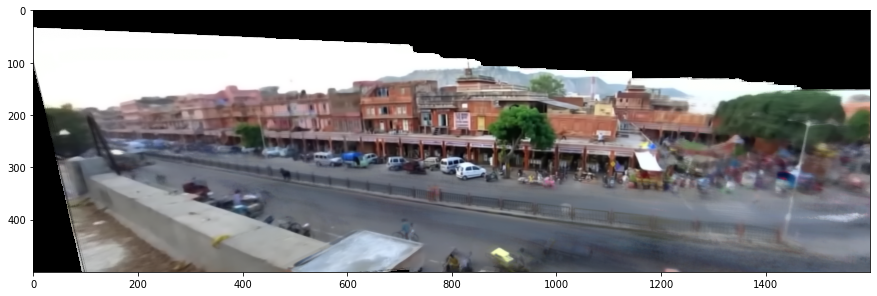

In [14]:
# Display background image using np array calculated in previous cell
plt.figure(figsize=(15,15))
plt.imshow(background[:,:,[2,1,0]]/255)

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [16]:
# TO DO part 5

# We need to compute the inverse homographies in order to convert from the 
# single plane panoramic view back to the individual planes of each frame 

b_height,b_width,c = im1.shape
background_frames = np.zeros((frameCount, b_height, b_width, c),dtype=np.uint8)
# print(background_frames.shape)
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

for f in range(0,frameCount):
  Tinv = np.linalg.inv(Tr.dot(Hs[f]))
  empty_background = cv2.warpPerspective(background, Tinv, (b_width, b_height))
  # cv2.imwrite(datadir + "empty/a{:04d}.jpg".format(f+1), empty_background)
  background_frames[f] = empty_background

In [96]:
# Make empty background video from frames calculated in last cell
utils.imageFolder2mpeg(datadir + 'empty', output_path = datadir + 'results/empty_video.mpeg', fps=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [148]:
# TO DO part 6

# Calculate euclidian color distance to background by comparing it to each pixel 
# of projected frame; If it is above certain distance, use it
# If not above threshold, make all pixels gray?

foreground_frames = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8)
# gray = np.zeros((frameCount, projectedHeight, projectedWidth, c),dtype=np.uint8) + 150
for f in range(0,frameCount):
  diff = projected_frames[f] - background
  dist = np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2).astype(np.uint8)
  mask = np.zeros((projectedHeight, projectedWidth,3))
  # dist = np.linalg.norm(projected_frames[f]-background,axis=2)
  # print(np.average(background_frames[f],axis=2) > 100)
  # consider = np.logical_and(dist < 10, (np.average(background_frames[f],axis=2) < 230)) 
  f_idx = np.argwhere(dist > 50)
  # f_idx = np.nonzero(consider)
  mask[f_idx[:,0],f_idx[:,1], :] = 1
  
  # dists = np.array([dist,dist,dist])
  # foreground_frames[f] = np.where(dists > 1, frames[f], [0,0,0])
  mask = cv2.GaussianBlur(mask, (3, 3), cv2.BORDER_DEFAULT)
  foreground_frames[f] = projected_frames[f]*mask

# plt.imshow(projected_frames[4][:,:,[2,1,0]])
# plt.figure()
# plt.imshow(background[:,:,[2,1,0]]/255)
# plt.figure()
# plt.imshow(dist, cmap = 'gray')
# plt.figure()
# plt.imshow(mask, cmap = 'gray')
# plt.figure()
# plt.imshow(foreground_frames[4][:,:,[2,1,0]])

In [149]:
# Convert back to original size

b_height,b_width,c = im1.shape
fg_small_frames = np.zeros((frameCount, b_height, b_width, c),dtype=np.uint8)
# print(background_frames.shape)
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

for f in range(0,frameCount):
  Tinv = np.linalg.inv(Tr.dot(Hs[f]))
  foreground = cv2.warpPerspective(foreground_frames[f], Tinv, (b_width, b_height))
  # cv2.imwrite(datadir + "empty/a{:04d}.jpg".format(f+1), empty_background)
  fg_small_frames[f] = foreground

In [150]:
# Make empty background video from frames calculated in last cell
# utils.imageFolder2mpeg(datadir + 'empty', output_path = datadir + 'results/empty_video.mpeg', fps=30)

utils.vidwrite_from_numpy(datadir + 'results/small_fg_video.mpeg', fg_small_frames[:,:,:,[2,1,0]], framerate=30)


## Bells and whistles

### Wide Video

In [175]:
# Wide Video: 

b_height,b_width,c = im1.shape
new_width = int(1.6*b_width)
wide_frames = np.zeros((frameCount, b_height, new_width, c),dtype=np.uint8)
# print(background_frames.shape)
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

for f in range(0,frameCount):
  Tinv = np.linalg.inv(Tr.dot(Hs[f]))
  wide_background = cv2.warpPerspective(background, Tinv, (new_width, b_height))
  # cv2.imwrite(datadir + "empty/a{:04d}.jpg".format(f+1), empty_background)
  wide_frames[f] = wide_background

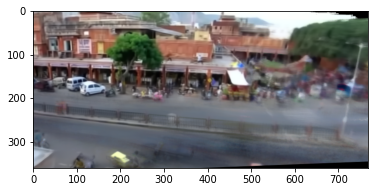

In [177]:
plt.imshow(wide_frames[500][:,:,[2,1,0]])

In [178]:
# Make empty background video from frames calculated in last cell
utils.vidwrite_from_numpy(datadir + 'results/wide_video.mpeg', wide_frames[:,:,:,[2,1,0]], framerate=30)

### Smooth Blending

In [179]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

# Read all images into np array called frames of length n, the number of key frames
frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution

projectedWidth = 1600
projectedHeight = 500

# First computer homographies between frames 270/630, and 450. frames[2] is f450, the central frame

H12 = auto_homography(frames[1],frames[2], computeHomography)
H32 = auto_homography(frames[3],frames[2], computeHomography)
H01 = auto_homography(frames[0],frames[1], computeHomography)
H43 = auto_homography(frames[4],frames[3], computeHomography)
H02 = np.dot(H01,H12)
H42 = np.dot(H43,H32)

best score: 155.000000
best score: 138.000000
best score: 209.000000
best score: 103.000000


Old Blend iinitial 255.0


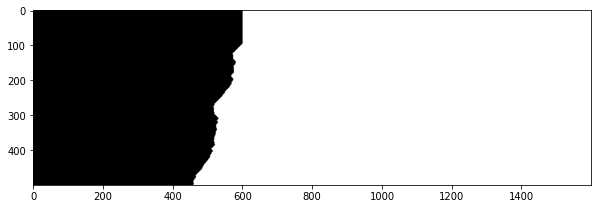

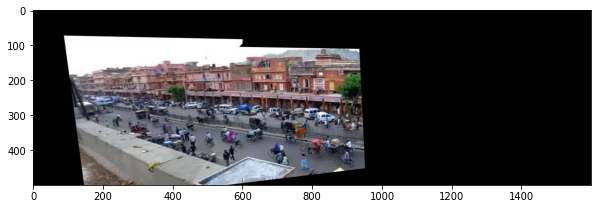

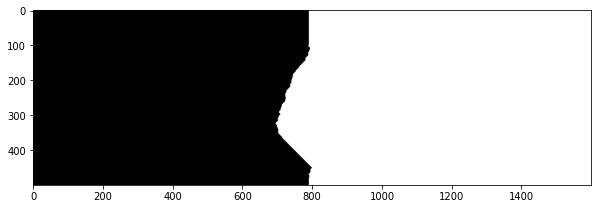

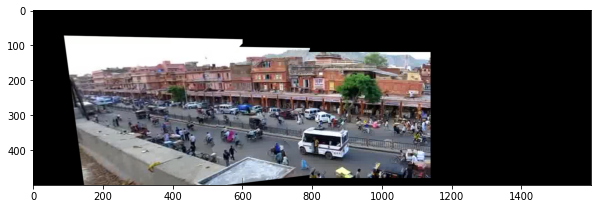

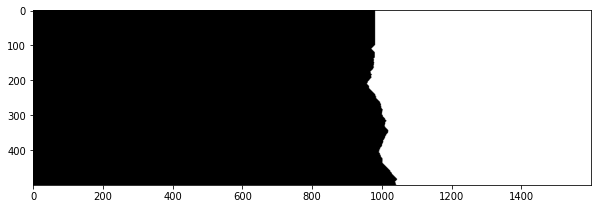

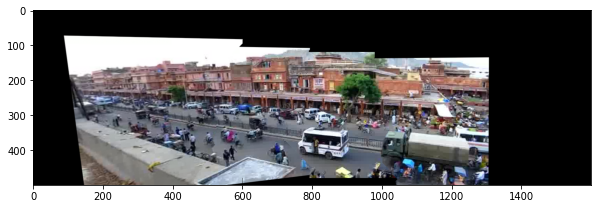

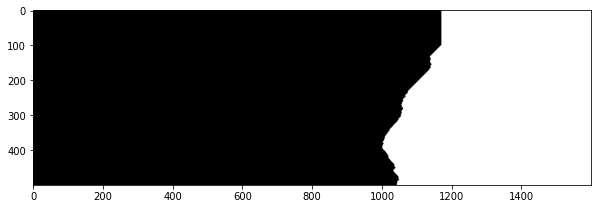

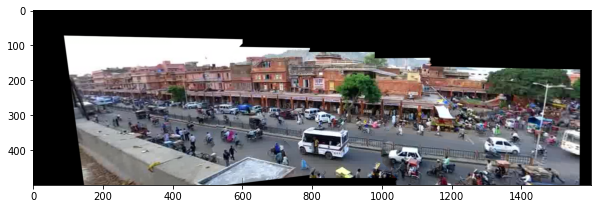

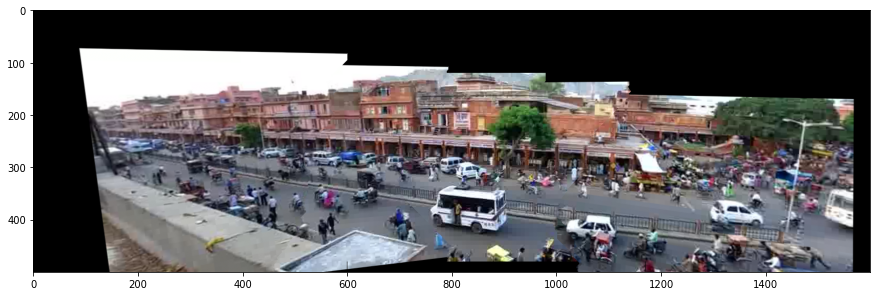

In [291]:
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])
Tr_f = Tr.astype(np.float32)

# Create the five images we want to blend
projs = np.zeros((5, projectedHeight, projectedWidth, 3))
projs[0] = cv2.warpPerspective(frames[0], Tr.dot(H02), (projectedWidth, projectedHeight))
projs[1] = cv2.warpPerspective(frames[1], Tr.dot(H12), (projectedWidth, projectedHeight))
projs[2] = cv2.warpPerspective(frames[2], Tr_f, (projectedWidth, projectedHeight))
projs[3] = cv2.warpPerspective(frames[3], Tr.dot(H32), (projectedWidth, projectedHeight))
projs[4] = cv2.warpPerspective(frames[4], Tr.dot(H42), (projectedWidth, projectedHeight))

# Put the five images into one with smooth blending
# Strategy: Go 

start = 0
end = projs.shape[0]
old_blend = projs[start]
print("Old Blend iinitial", np.max(old_blend))
for i in range(start+1,end):
  # plt.figure(figsize=(10,10))
  # plt.imshow(old_blend[:,:,[2,1,0]])
  projs[i,0:100,410+190*i,:] = 1
  projs[i,-20:-1,410+190*i,:] = 1
  # print("new image", np.max(projs[i]))
  blend = blend_smooth(projs[i], old_blend)
  old_blend = blend*255
  # print("Old Blend", np.max(old_blend))
  plt.figure(figsize=(10,10))
  plt.imshow(blend[:,:,[2,1,0]])

plt.figure(figsize=(15,15))
plt.imshow(blend[:,:,[2,1,0]])

In [271]:
def blend_smooth(new, old):
  old = old/255
  new = new/255
  t1, t2, t3 = cv2.split(old)
  p1, p2, p3 = cv2.split(new)
  height = old.shape[0]
  width = old.shape[1]

  cost = (t1-p1)**2 + (t2-p2)**2 + (t3-p3)**2 # Calculate pixel-wise sum of squared differences between template and chosen patch
  cost = np.where(cost == 0, 10, cost)
  mask = np.zeros((height,width),np.uint8)
  mask = cut(cost.T).T
  # print(np.max(cost))
  # plt.figure(figsize=(15,15))
  # plt.imshow(cost, cmap = 'gray')

  c_mask = np.zeros((height,width,3),np.uint8)
  c_mask[:,:,0] = mask
  c_mask[:,:,1] = mask
  c_mask[:,:,2] = mask
  
  result = old*(1-c_mask) + new*(c_mask)

  # plt.figure(figsize=(10,10))
  # plt.imshow(old)

  plt.figure(figsize=(10,10))
  # plt.imshow(new[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(old[:,:,[2,1,0]])
  plt.imshow(mask, cmap = 'gray')
  return result

  # plt.figure()
  # plt.imshow(old[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(new[:,:,[2,1,0]])
  # plt.figure()
  # plt.imshow(mask, cmap = 'gray')
  # plt.figure()
  # plt.imshow(result[:,:,[2,1,0]])

In [182]:
# Taken from project 2 utils.py

def cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]
    
    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask